#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

__Задача:__ Построить модель для предсказания количества заказов такси на следующий час. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

In [1]:
import pandas as pd
import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(15,4)})
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

## Подготовка

### Загрузим и изучим данные

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

In [3]:
print(f"Начало времненного ряда: {data.index.min()}")
print(f"Конец временного ряда: {data.index.max()}")

Начало времненного ряда: 2018-03-01 00:00:00
Конец временного ряда: 2018-08-31 23:50:00


In [4]:
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В нашем распоряжении количество заказов такси с марта по август 2018 года с периодичностью в 10 минут.

### Проверим пропуски

In [5]:
print(f"Количество пропусков: {data.isna().sum()}")

Количество пропусков: num_orders    0
dtype: int64


### Ресемплируем данные по часу

In [6]:
hour_data = data.resample('1H').sum()
hour_data.sample(5)

,num_orders
datetime,
2018-06-14 16:00:00,107
2018-04-06 12:00:00,50
2018-03-18 03:00:00,35
2018-04-07 08:00:00,63
2018-03-09 21:00:00,70


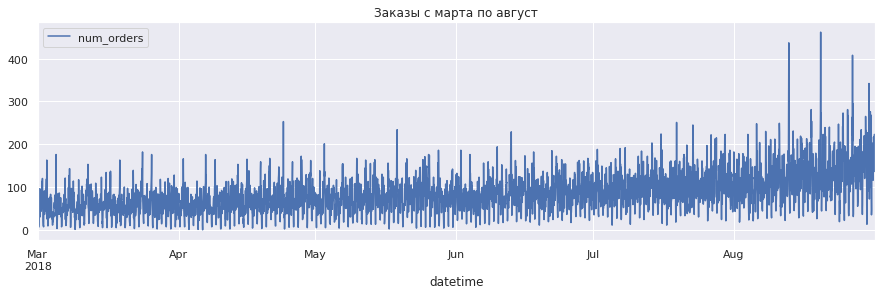

In [7]:
hour_data.plot()
plt.title('Заказы с марта по август')
plt.show()

Данные без пропусков, распределены по часам и готовы к анализу.

## Анализ

### Анализ среднего и дисперсии с использованием скользящего окна.

Посмотрим на среднее и дисперсию данного временного ряда

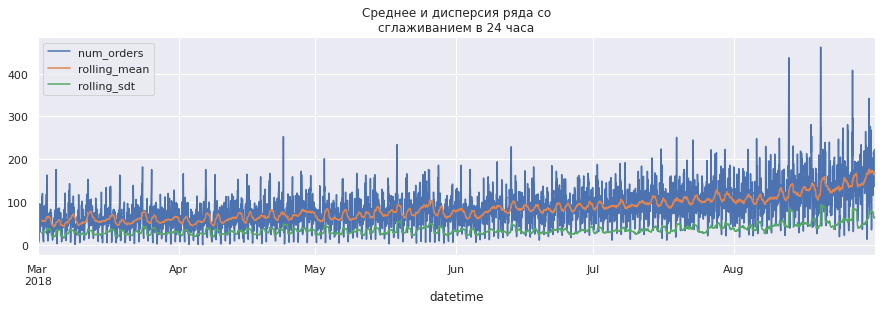

In [8]:
hour_data['rolling_mean'] = hour_data['num_orders'].rolling(24).mean()
hour_data['rolling_sdt'] = hour_data['num_orders'].rolling(24).std()

hour_data.plot()
plt.title('Среднее и дисперсия ряда со\nсглаживанием в 24 часа')
None

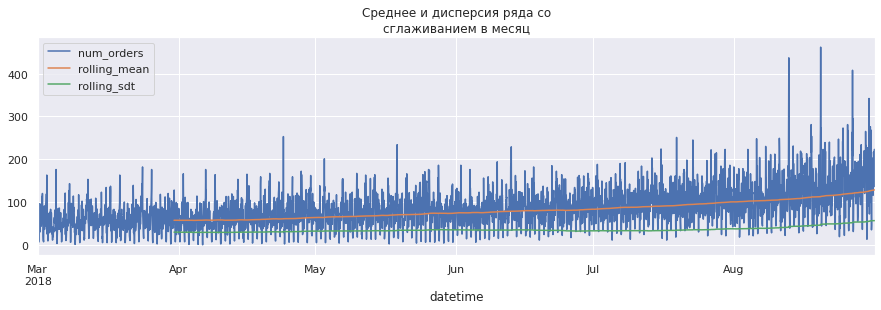

In [9]:
hour_data['rolling_mean'] = hour_data['num_orders'].rolling(720).mean()
hour_data['rolling_sdt'] = hour_data['num_orders'].rolling(720).std()

hour_data.plot()
plt.title('Среднее и дисперсия ряда со\nсглаживанием в месяц')
None

In [10]:
hour_data.drop(columns=['rolling_sdt', 'rolling_mean'], inplace=True)

Временной ряд имеет небольшой тренд на увеличение заказов такси с марта по август. Дисперсия растет ближе к августу.

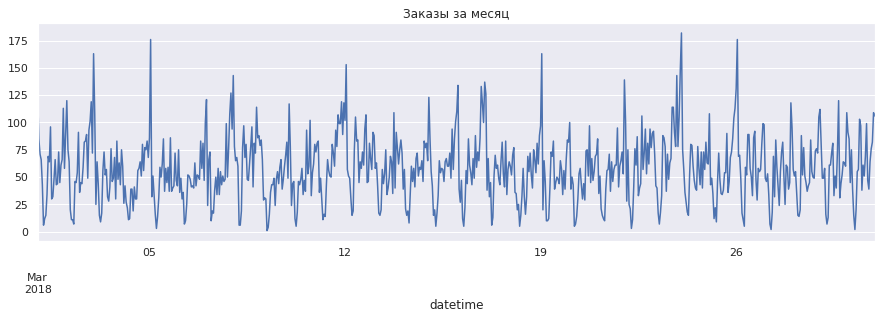

In [11]:
hour_data.iloc[0:720, 0].plot()
plt.title('Заказы за месяц')
None

**Промежуточный вывод:** Временной ряд имеет тренд на рост числа заказов от марта к августу. В тоже время наблюдается некоторая сезонность.

### Проанализируем тренд, сезонность и шум ряда

Среднее растет с марта по август. Проверим ряд на стационарность критерием Дики-Фуллера.

In [12]:
st_test = adfuller(hour_data['num_orders'], regression='ctt')

In [13]:
print ('adf: ', st_test[0])
print ('p-value: ', st_test[1])
print ('Critical values: ', st_test[4])
if st_test[0]> st_test[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен')

adf:  -10.891452237749158
p-value:  4.0549397892403547e-17
Critical values:  {'1%': -4.373775161444573, '5%': -3.8337377543683258, '10%': -3.554095038926073}
Единичных корней нет, ряд стационарен


Не смотря на небольшое увеличение среднего значения, исследуемый временной ряд является стационарным.

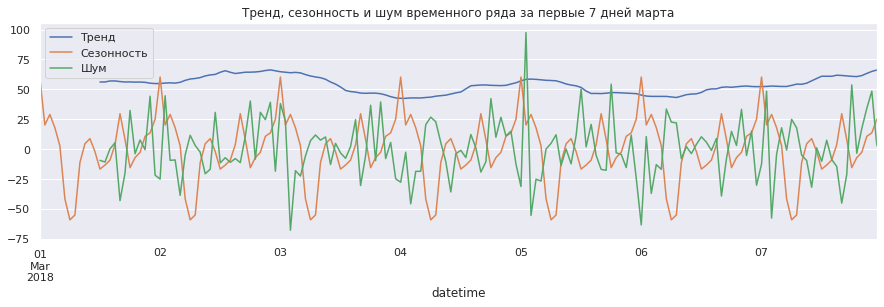

In [14]:
decomposed = seasonal_decompose(hour_data['num_orders'])

plt.title('Тренд, сезонность и шум временного ряда за первые 7 дней марта')
decomposed.trend.head(24*7).plot()
decomposed.seasonal.head(24*7).plot()
decomposed.resid.head(24*7).plot()
plt.legend(['Тренд', "Сезонность", "Шум"])
None

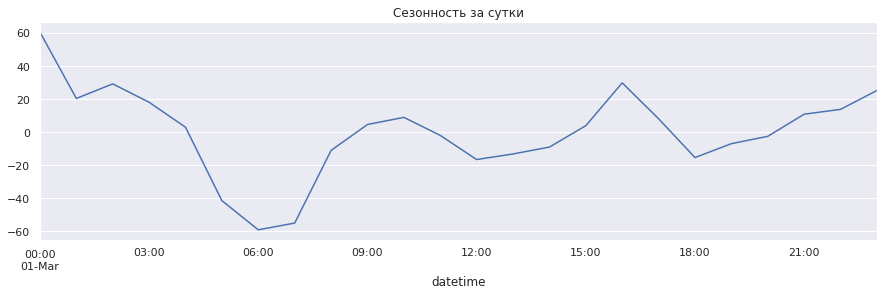

In [15]:
plt.title('Сезонность за сутки')
decomposed.seasonal.head(24).plot()
None

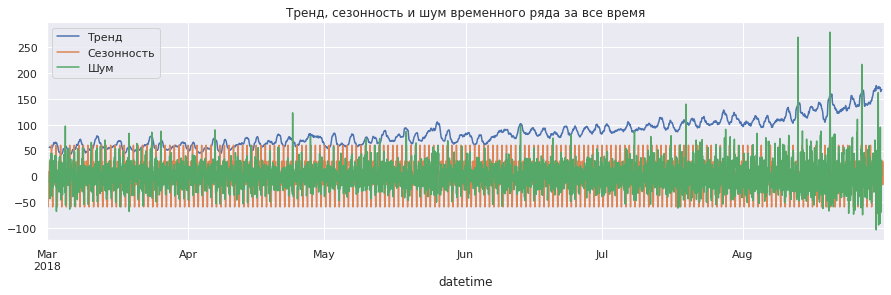

In [16]:
plt.title('Тренд, сезонность и шум временного ряда за все время')
decomposed.trend.plot()
decomposed.seasonal.plot()
decomposed.resid.plot()
plt.legend(['Тренд', "Сезонность", "Шум"])
None

Проверим ряд на недельную сезонность.

Text(0.5, 1.0, 'Недельная сезонность')

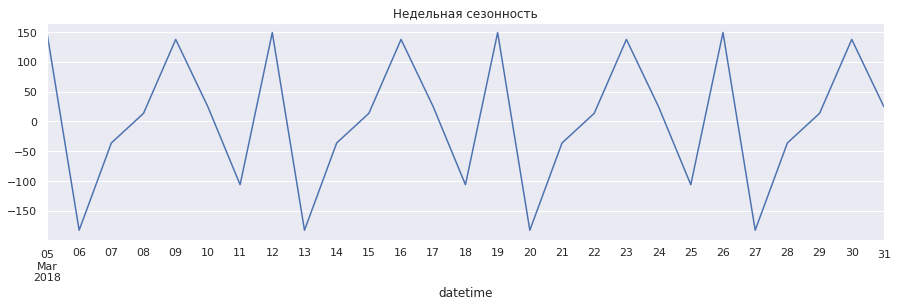

In [17]:
day_data = hour_data.resample('1D').sum()
decomp_days = seasonal_decompose(day_data['num_orders'])
decomp_days.seasonal[4:31].plot()
# decomp_days.trend[0:31].plot()

plt.title('Недельная сезонность')

В ряде наблюдается две сезонности: 

* Суточная сезонность и говорит о том, что количество заказов падает с полуночи до 6 утра и снова начинает расти. 
* Недельная сезонность говорит о том, что пик заказов приходится на понедельник и пятницу. Меньше всего заказов происходит по вторникам и средам.
* День недели и время заказа будут важными признаками для модели.

Также в августе увеличивается шум.

## Обучение

Разобьем выборку на тренировочную и обучающую. Важно сохранить последовательность наблюдений.

In [18]:
train, test = train_test_split(hour_data, shuffle=False, test_size=0.1)

Добавим результаты RMSE в лист.

In [19]:
model_stats = []

### Попробуем спрогнозировать ряд при помощи модели авторегрессии скользящего среднего ARIMA

Подберем компоненты для модели.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


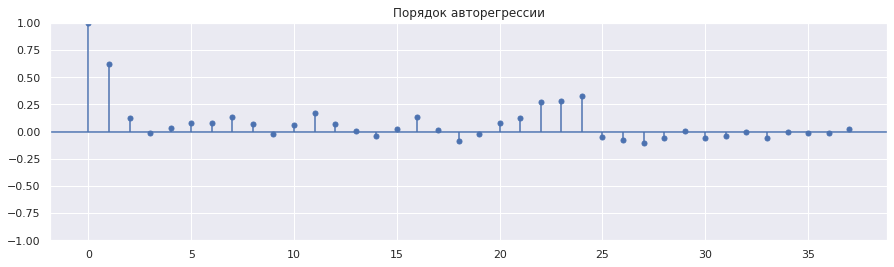

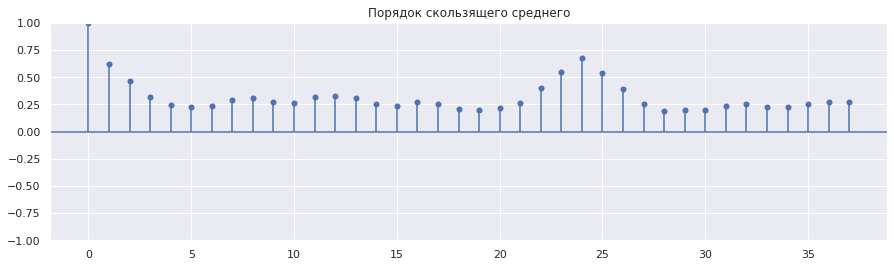

In [20]:
plot_pacf(hour_data, alpha=None)
plt.title('Порядок авторегрессии')
plt.show()

plot_acf(hour_data, alpha=None)
plt.title('Порядок скользящего среднего')
plt.show()

Наименьшие значения порядков авторегрессии и скользящего среднего достигаютсяв точках 2 и 4 соответственно.

In [21]:
%%time
decomposition = seasonal_decompose(train) 
arima_model = ARIMA(train, order=(2,1,4))
arima_model = arima_model.fit()

CPU times: user 6.22 s, sys: 9.35 s, total: 15.6 s
Wall time: 15.6 s


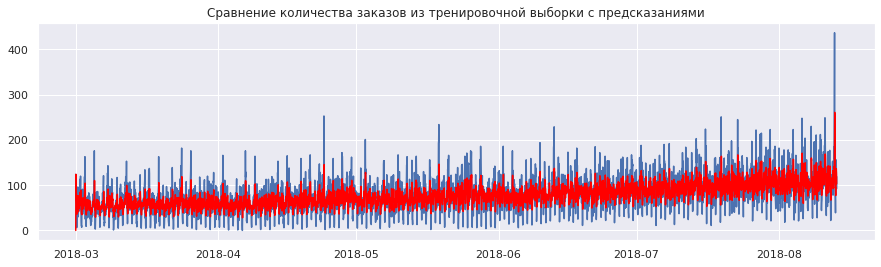

In [22]:
plt.plot(train['num_orders'])
plt.plot(arima_model.fittedvalues, color='red')
plt.title('Сравнение количества заказов из тренировочной выборки с предсказаниями')
None

In [23]:
rmse = mean_squared_error(train['num_orders'], arima_model.fittedvalues, squared=False)
print(rmse)
model_stats.append([arima_model, rmse])

30.77400389932446


### Обучение стандартных моделей

#### Сгенерируем дополнительные признаки для обучения других моделей

* Сгенерируем отставания
* Так как была показана сезонность в зависимости времени и дня недели, добавим эти признаки в модель

In [24]:
for dataframe in [test, train]:    
    # сгенерируем отставания
    for step in [2, 8, 12]:
        dataframe[f'lag_{step}'] = dataframe['num_orders'].shift(step).fillna(method='bfill')
    for window_size in [4, 9, 14]:
        dataframe[f'ma_{window_size}'] = dataframe['num_orders'].rolling(window_size).mean().fillna(method='bfill')

    dataframe['day'] = dataframe.index.day
    dataframe['dayofweek'] = dataframe.index.dayofweek
    dataframe['hour'] = dataframe.index.hour

/tmp/ipykernel_345/2704309476.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[f'lag_{step}'] = dataframe['num_orders'].shift(step).fillna(method='bfill')
/tmp/ipykernel_345/2704309476.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[f'ma_{window_size}'] = dataframe['num_orders'].rolling(window_size).mean().fillna(method='bfill')
/tmp/ipykernel_345/2704309476.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [25]:
test.sample(10)

,num_orders,lag_2,lag_8,lag_12,ma_4,ma_9,ma_14,day,dayofweek,hour
datetime,,,,,,,,,,
2018-08-29 04:00:00,136,163.0,94.0,148.0,144.25,159.222222,157.142857,29,2,4
2018-08-23 09:00:00,135,38.0,198.0,137.0,80.50,125.666667,130.357143,23,3,9
2018-08-25 02:00:00,160,273.0,137.0,88.0,213.00,187.666667,171.142857,25,5,2
2018-08-24 00:00:00,247,130.0,180.0,143.0,182.25,159.222222,144.428571,24,4,0
2018-08-21 16:00:00,128,121.0,91.0,216.0,110.50,115.000000,116.214286,21,1,16
2018-08-14 15:00:00,116,64.0,54.0,190.0,101.50,111.444444,109.428571,14,1,15
2018-08-22 02:00:00,197,240.0,94.0,121.0,181.75,142.666667,134.785714,22,2,2
2018-08-20 01:00:00,272,167.0,210.0,134.0,190.00,151.777778,146.000000,20,0,1
2018-08-27 06:00:00,31,295.0,145.0,127.0,149.00,208.000000,180.214286,27,0,6


##### Разобьем выборки на целевой признак и фичи

In [26]:
X_train = train.drop(columns='num_orders')
y_train = train['num_orders']

X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

##### Создадим предсказание - заглушку

In [27]:
dummy_pred = np.ones(y_train.shape[0]) * y_train.mean()
rmse = mean_squared_error(y_train, dummy_pred, squared=False)
print(rmse)
model_stats.append(['dummy', rmse])

38.66694570860161


#### Ridge

Чтобы не допустить утечки данных при кросс валидации, используем TimeSeriesSplit

In [28]:
tsp = TimeSeriesSplit(n_splits=5)

In [29]:
%%time
# определим параметры
parameters = {'alpha':np.arange(0, 16, 0.5).tolist(),
              'fit_intercept': [True, False]}

# выберем модель
model = Ridge()

# подберем параметры
Ridge_reg = RandomizedSearchCV(model, parameters, scoring='neg_root_mean_squared_error', cv=tsp, verbose=3, random_state=42)

Ridge_reg.fit(X_train, y_train)

# лучшие параметры
print(Ridge_reg.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .................alpha=13.0, fit_intercept=True; total time=   0.0s
[CV 2/5] END .................alpha=13.0, fit_intercept=True; total time=   0.0s
[CV 3/5] END .................alpha=13.0, fit_intercept=True; total time=   0.0s
[CV 4/5] END .................alpha=13.0, fit_intercept=True; total time=   0.0s
[CV 5/5] END .................alpha=13.0, fit_intercept=True; total time=   0.0s
[CV 1/5] END .................alpha=14.5, fit_intercept=True; total time=   0.1s
[CV 2/5] END .................alpha=14.5, fit_intercept=True; total time=   0.0s
[CV 3/5] END .................alpha=14.5, fit_intercept=True; total time=   0.0s
[CV 4/5] END .................alpha=14.5, fit_intercept=True; total time=   0.0s
[CV 5/5] END .................alpha=14.5, fit_intercept=True; total time=   0.0s
[CV 1/5] END ..................alpha=0.0, fit_intercept=True; total time=   0.0s
[CV 2/5] END ..................alpha=0.0, fit_in

In [30]:
%%time
# best model
best_ridge = Ridge_reg.best_estimator_
best_ridge.fit(X_train, y_train)

predictions = best_ridge.predict(X_train)
rmse = mean_squared_error(y_train, predictions, squared=False)
print(f"RMSE Ridge: {rmse}")

RMSE Ridge: 22.990979541796566
CPU times: user 8.26 ms, sys: 15.2 ms, total: 23.5 ms
Wall time: 6.72 ms


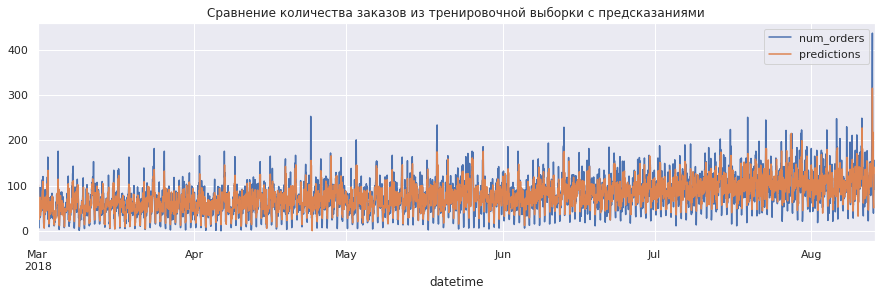

In [31]:
test_df = pd.DataFrame(y_train)
test_df['predictions'] = predictions.tolist()
test_df.plot()
plt.title('Сравнение количества заказов из тренировочной выборки с предсказаниями')
None

In [32]:
model_stats.append([best_ridge, rmse])

#### RandomForest regressor

In [33]:
%%time
# определим параметры
parameters = { 
    'n_estimators': [20, 50, 100, 200],
    'max_depth' : [3,5,8],
}

# выберем модель
model = RandomForestRegressor(random_state=42)

# подберем параметры
rfr = RandomizedSearchCV(model, parameters, scoring='neg_root_mean_squared_error', cv=tsp, verbose=3, random_state=42)
rfr.fit(X_train, y_train)

# лучшие параметры
print(rfr.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..................max_depth=8, n_estimators=100; total time=   0.3s
[CV 2/5] END ..................max_depth=8, n_estimators=100; total time=   0.4s
[CV 3/5] END ..................max_depth=8, n_estimators=100; total time=   0.6s
[CV 4/5] END ..................max_depth=8, n_estimators=100; total time=   0.7s
[CV 5/5] END ..................max_depth=8, n_estimators=100; total time=   0.9s
[CV 1/5] END ...................max_depth=8, n_estimators=50; total time=   0.1s
[CV 2/5] END ...................max_depth=8, n_estimators=50; total time=   0.2s
[CV 3/5] END ...................max_depth=8, n_estimators=50; total time=   0.3s
[CV 4/5] END ...................max_depth=8, n_estimators=50; total time=   0.4s
[CV 5/5] END ...................max_depth=8, n_estimators=50; total time=   0.5s
[CV 1/5] END ...................max_depth=3, n_estimators=20; total time=   0.0s
[CV 2/5] END ...................max_depth=3, n_e

In [34]:
%%time
# best model
best_rfr = rfr.best_estimator_
best_rfr.fit(X_train, y_train)

y_predict = best_rfr.predict(X_train)
rsme = mean_squared_error(y_train, y_predict, squared=False)
print(f"RSME модели случайного леса: {rsme}")

RSME модели случайного леса: 15.249300260428647
CPU times: user 1.98 s, sys: 13.4 ms, total: 1.99 s
Wall time: 2 s


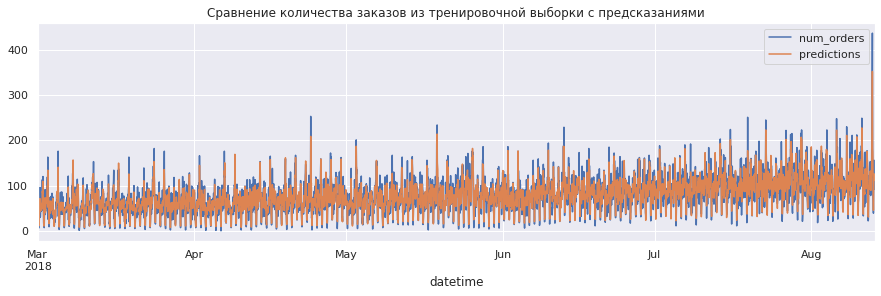

In [35]:
test_df = pd.DataFrame(y_train)
test_df['predictions'] = y_predict.tolist()
test_df.plot()
plt.title('Сравнение количества заказов из тренировочной выборки с предсказаниями')
None

In [36]:
model_stats.append([best_rfr, rmse])

#### Catboost

In [37]:
%%time
catboost = CatBoostRegressor(verbose=True, random_state=42)
catboost.fit(X_train, y_train, verbose=True)
predictions = catboost.predict(X_train)
rmse = mean_squared_error(y_train, predictions, squared=False)
print(f"RSME CatBoost: {rsme}")

Learning rate set to 0.050916
0:	learn: 37.5520143	total: 49.1ms	remaining: 49s
1:	learn: 36.5183184	total: 51.1ms	remaining: 25.5s
2:	learn: 35.5181708	total: 53ms	remaining: 17.6s
3:	learn: 34.5740526	total: 55ms	remaining: 13.7s
4:	learn: 33.6786438	total: 57ms	remaining: 11.3s
5:	learn: 32.8246798	total: 58.9ms	remaining: 9.76s
6:	learn: 32.0741944	total: 60.8ms	remaining: 8.63s
7:	learn: 31.3241944	total: 62.9ms	remaining: 7.79s
8:	learn: 30.6896809	total: 64.8ms	remaining: 7.13s
9:	learn: 30.0700510	total: 66.7ms	remaining: 6.61s
10:	learn: 29.4363313	total: 68.4ms	remaining: 6.15s
11:	learn: 28.8339368	total: 70.4ms	remaining: 5.79s
12:	learn: 28.2763451	total: 72.2ms	remaining: 5.48s
13:	learn: 27.8089570	total: 74.3ms	remaining: 5.23s
14:	learn: 27.3542172	total: 76.2ms	remaining: 5.01s
15:	learn: 26.9450267	total: 78.1ms	remaining: 4.8s
16:	learn: 26.5990887	total: 80ms	remaining: 4.62s
17:	learn: 26.1606968	total: 81.8ms	remaining: 4.46s
18:	learn: 25.7770837	total: 83.6ms	r

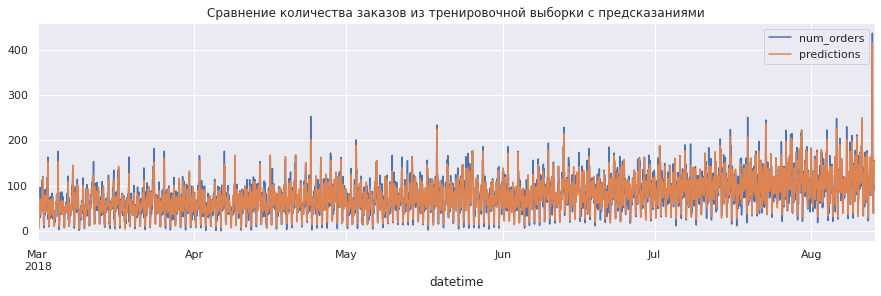

In [38]:
test_df = pd.DataFrame(y_train)
test_df['predictions'] = predictions.tolist()
test_df.plot()
plt.title('Сравнение количества заказов из тренировочной выборки с предсказаниями')
None

In [39]:
model_stats.append([catboost, rmse])

#### LightGBM

In [40]:
%%time
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
predictions = lgbm.predict(X_train)
rmse = mean_squared_error(y_train, predictions, squared=False)
print(f"RSME LightGBM модели: {rsme}")

RSME LightGBM модели: 15.249300260428647
CPU times: user 5min 29s, sys: 2.17 s, total: 5min 31s
Wall time: 5min 33s


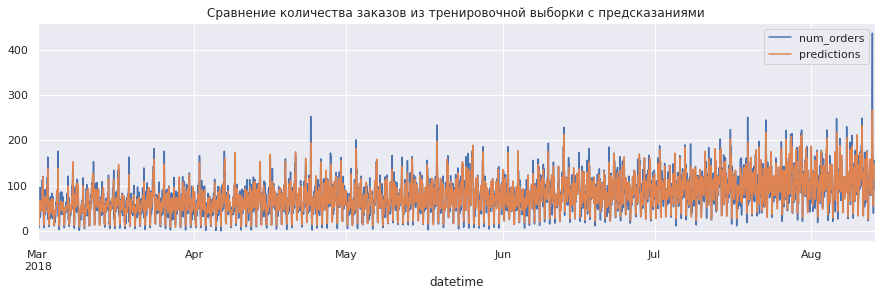

In [41]:
test_df = pd.DataFrame(y_train)
test_df['predictions'] = predictions.tolist()
test_df.plot()
plt.title('Сравнение количества заказов из тренировочной выборки с предсказаниями')
None

In [42]:
model_stats.append([lgbm, rmse])

### Результаты обучения моделей

In [43]:
train_results = pd.DataFrame(model_stats, columns=['model', 'rmse_train']).sort_values(by='rmse_train')
display(train_results)

,model,rmse_train
4,<catboost.core.CatBoostRegressor object at 0x7...,11.220446
5,LGBMRegressor(random_state=42),12.364311
2,Ridge(alpha=14.5),22.990980
3,"(DecisionTreeRegressor(max_depth=8, max_featur...",22.990980
0,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,30.774004
1,dummy,38.666946


__Вывод:__ На тренировочной выборке самой быстрой и точной моделью оказалась модель градиентного бустинга CatBoost. Проверим ее на тренировочной.

## Тестирование

In [44]:
test_predict = catboost.predict(X_test)
rmse = mean_squared_error(y_test, test_predict, squared=False)
print(f"RMSE Ridge на тестовой выборке: {rmse}")

RMSE Ridge на тестовой выборке: 36.98952263430309


In [45]:
test_df = pd.DataFrame(y_test)
test_df['predictions'] = test_predict.tolist()
test_df

,num_orders,predictions
datetime,,
2018-08-13 14:00:00,102,138.714137
2018-08-13 15:00:00,175,145.239177
2018-08-13 16:00:00,144,158.918925
2018-08-13 17:00:00,152,118.923854
2018-08-13 18:00:00,104,130.369152
...,...,...
2018-08-31 19:00:00,136,124.570387
2018-08-31 20:00:00,154,142.052752
2018-08-31 21:00:00,159,177.446230


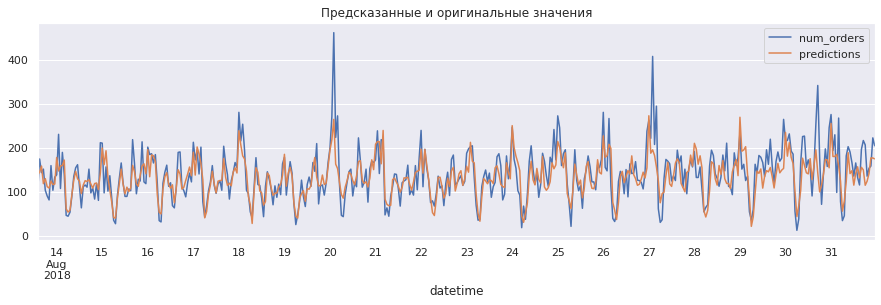

In [46]:
test_df.plot()
plt.title('Предсказанные и оригинальные значения')
None

## Вывод

* В ходе работы было показано, что ряд стационарный.
* Для обучения моделей мы определили порядки авторегрессии и скользящего среднего, после чего сгенерировали новые признаки.
* Провели сравнение моделей ARIMA, Ridge, случайного леса, CatBoost и LigtGBM.
* Наиболее быстрой и точной моделью стала модель CaBoost с RMSE на тестовой выборке 36.99.